In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pickle

# gz 확장자 압축 해제

In [2]:
# !tar xvzf Criteo_Conversion_Search_4.tar.gz

# 파일 DF 형태로 불러오기

In [3]:
f = open('./Criteo_Conversion_Search/CriteoSearchData','r')

df = []
for _ in tqdm(range(1500000)):
    line = f.readline()
    line = line.replace('\n','')
    df.append(line.split('\t'))

  0%|          | 0/1500000 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(df)
df.columns = ['Sale','SaleAmountInEuro','Time_delay_for_conversion',
                'click_timestamp','nb_clicks_1week','product_price','product_age_group','device_type',
                'audience_id','product_gender','product_brand','product_category1', 'product_category2',
                'product_category3','product_category4','product_category5','product_category6',
                'product_category7','product_country','product_id','product_title','partner_id','user_id']

# 주어진 과제에 맞게, Data Processing

## 1. 데이터 선택

- target label은 데이터 세트의 첫번째 컬럼을 사용
- 각 데이터는 20개의 feature를 갖는다

In [5]:
data = df.copy()

In [6]:
# 과제에서 label_columns 중 빼라고 한, SaleAmountInEuro와 Time_delay_for_conversion 변수 삭제
unused_label_columns = ['SaleAmountInEuro', 'Time_delay_for_conversion']
data = data.drop(unused_label_columns, axis=1)

## 2. 특정 값으로 지정한 결측치, nan으로 변경

- 대부분의 변수의 결측치는 '-1'로 지정됨
- click_time_stamp 변수의 결측치만 '0'으로 지정됨

In [7]:
for col in data.columns:
    
    # click_time_stamp 변수의 결측치만 '0'으로 지정됨
    if col == 'click_timestamp':
        data.loc[data[data[col]=='0'].index, col] = np.nan
    
    # 대부분의 변수의 결측치는 '-1'로 지정됨
    else:
        data.loc[data[data[col]=='-1'].index, col] = np.nan

In [8]:
def summary(data):
    frame_info = []
    for col in data.columns:
        # column, column unique 길이, column null 갯수, column 데이터 형태, column 데이터
        frame_info.append([col, len(data[col].unique()), data[col].isnull().sum(), data[col].isnull().sum()/len(data)*100, data[col].dtype, data[col].unique()[:5]])

    # frame_info를 dataframe 형태로 변환
    df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'ratio_of_nan', 'dtype', 'front5_values'])
    return df_info

In [9]:
summary(data)

,name,num_of_unique,num_of_nan,ratio_of_nan,dtype,front5_values
0,Sale,2,0,0.000000,object,"[0, 1]"
1,click_timestamp,1290642,0,0.000000,object,"[1598891820, 1598925284, 1598892568, 159889117..."
2,nb_clicks_1week,4044,642109,42.807267,object,"[nan, 0, 9, 1, 234]"
3,product_price,17596,0,0.000000,object,"[0.0, 49.95, 158.33, 10.74, 13.19]"
4,product_age_group,11,1107595,73.839667,object,"[nan, 4C90FD52FC53D2C1C205844CB69575AB, 0CD76C..."
5,device_type,7,271,0.018067,object,"[7E56C27BFF0305E788DA55A029EC4988, D7D1FB49049..."
6,audience_id,12153,1074442,71.629467,object,"[nan, B0E6BD3ACC0707BAB31CA2C2B08E652F, ED3775..."
7,product_gender,17,1096875,73.125000,object,"[nan, 1B491180398E2F0390E6A588B3BCE291, A5D15F..."
8,product_brand,25521,680072,45.338133,object,"[nan, 3CE3D1623D32FB2A901822910AF72A0B, 567889..."
9,product_category1,22,583226,38.881733,object,"[nan, 033E492229C2222EFAA16EE8A6462D8B, EC997D..."


## 3. 변수 설명에 맞게 타입 변환

- Sale : 전환이 발생한 경우 1을 표시하고 그렇지 않은 경우 0, int
- click_timestamp : 클릭의 타임스탬프, timestamp
- nb_clicks_1week : 지난 1 주일 동안 제품 관련 광고에서 발생한 클릭 수, int
- product_price : 광고에 표시된 제품의 가격, float
- product_age_group : 제품이 만들어진 사용자의 의도 된 사용자 연령 그룹, object(11개)
- device_type : 재 방문 사용자인지 모바일, 태블릿 또는 데스크톱의 신규 사용자인지, object(7게)
- audience_id :이 기능의 의미를 공개하지 않습니다, object(12153개)
- product_gender : 제품이 만들어진 사용자의 의도 된 성별, object(17개)
- product_brand : 제품 브랜드에 대한 카테고리 기능, object(25521개)
- product_category (1-7) : 제품과 관련된 범주 기능입니다. 우리는 이러한 기능의 의미를 공개하지 않습니다, object
- product_country : 제품이 판매되는 국가, object(19개)
- product_id : 모든 제품과 관련된 고유 식별자, object
- product_title : 제품의 해시 된 제목, object
- partner_id : 제품 판매자와 관련된 고유 식별자, object
- user_id : 모든 사용자와 관련된 고유 식별자, object

In [10]:
# Sale : int 형태로 변환
data = data.astype({'Sale' : int})

# click_timestamp : datetime 형태로 변환
data = data.astype({'click_timestamp' : int})
data['click_timestamp'] = [datetime.datetime.fromtimestamp(x) for x in data['click_timestamp']]

# nb_clicks_1week : int 형태로 변환
data['nb_clicks_1week'] = pd.to_numeric(data['nb_clicks_1week'], errors='coerce')

# product_price : float 형태로 변환
data['product_price'] = pd.to_numeric(data['product_price'], errors='coerce')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Sale               1500000 non-null  int32         
 1   click_timestamp    1500000 non-null  datetime64[ns]
 2   nb_clicks_1week    857891 non-null   float64       
 3   product_price      1500000 non-null  float64       
 4   product_age_group  392405 non-null   object        
 5   device_type        1499729 non-null  object        
 6   audience_id        425558 non-null   object        
 7   product_gender     403125 non-null   object        
 8   product_brand      819928 non-null   object        
 9   product_category1  916774 non-null   object        
 10  product_category2  916134 non-null   object        
 11  product_category3  805531 non-null   object        
 12  product_category4  511127 non-null   object        
 13  product_category5  130331 n

# 학습 데이터와 훈련 데이터 생성

In [12]:
df_train = data[:1000000]
df_test = data[1000000:]

In [13]:
print('학습 데이터 형태 : ', df_train.shape)
print('훈련 데이터 형태 : ', df_test.shape)

학습 데이터 형태 :  (1000000, 21)
훈련 데이터 형태 :  (500000, 21)


# Data Processing

## target variable
- Sale

In [14]:
df_train['Sale'].value_counts()

0    889930
1    110070
Name: Sale, dtype: int64

In [15]:
df_test['Sale'].value_counts()

0    442586
1     57414
Name: Sale, dtype: int64

## Features engineering

In [16]:
df_train['nb_clicks_1week'].hist()

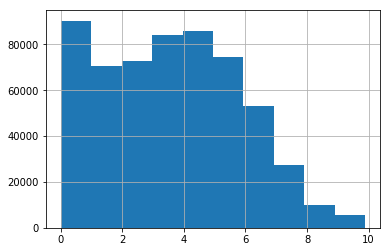

In [17]:
np.log1p(df_train['nb_clicks_1week']).hist()

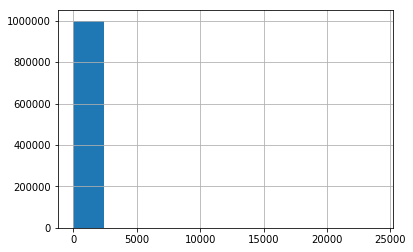

In [18]:
df_train['product_price'].hist()

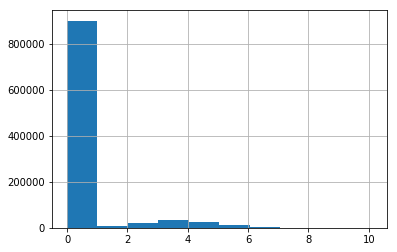

In [19]:
np.log1p(df_train['product_price']).hist()

In [20]:
df_train[['product_age_group','Sale']].groupby('product_age_group').mean()

,Sale
product_age_group,
0CD76C7030D0900BE250C8D41703D180,0.129373
3FEC071EF6B3D061D8804E0522FF4D2A,0.111111
4C90FD52FC53D2C1C205844CB69575AB,0.094473
538912C31E773613AB51FBAE58492476,0.129082
88460293E9517D21E39AA889BD5AADC8,0.093620
921B36149E5B081FD24450BFE2CE4430,0.149004
A443B40A19DB45968C2825CE225368DF,0.125373
D72D7E92251E4C54C786FDEFFA4DEF5A,0.202381
E7BD5A29457B8E92582951B586319A9C,0.201326


In [21]:
df_train[['product_category7','Sale']].groupby('product_category7').mean()

,Sale
product_category7,
C8A87115C9B5521CB91F63D589E2D7F4,0.250000
DAE53D1DEBF527CB677F4C79AA0DEC0D,0.333333
EE40DC4A754052FAC367C5D3E32C1422,0.000000


## 1. Missing data

In [22]:
df_train.isnull().sum()

Sale                      0
click_timestamp           0
nb_clicks_1week      425231
product_price             0
product_age_group    735462
device_type             177
audience_id          714461
product_gender       727508
product_brand        440251
product_category1    382751
product_category2    383185
product_category3    457748
product_category4    656148
product_category5    912709
product_category6    983076
product_category7    999990
product_country      233152
product_id           232878
product_title        382751
partner_id                0
user_id                   0
dtype: int64

In [23]:
df_test.isnull().sum()

Sale                      0
click_timestamp           0
nb_clicks_1week      216878
product_price             0
product_age_group    372133
device_type              94
audience_id          359981
product_gender       369367
product_brand        239821
product_category1    200475
product_category2    200681
product_category3    236721
product_category4    332725
product_category5    456960
product_category6    491812
product_category7    499998
product_country      118197
product_id           117999
product_title        200475
partner_id                0
user_id                   0
dtype: int64

## 2. data correlation & 정규화

In [24]:
corr = df_train.corr()
corr

,Sale,nb_clicks_1week,product_price
Sale,1.000000,-0.031454,0.279352
nb_clicks_1week,-0.031454,1.000000,0.005568
product_price,0.279352,0.005568,1.000000


In [25]:
corr = df_test.corr()
corr

,Sale,nb_clicks_1week,product_price
Sale,1.000000,-0.035383,0.278369
nb_clicks_1week,-0.035383,1.000000,0.005530
product_price,0.278369,0.005530,1.000000


In [26]:
df_train['nb_clicks_1week'] = np.log1p(df_train['nb_clicks_1week'])
df_train['product_price'] = np.log1p(df_train['product_price'])

df_test['nb_clicks_1week'] = np.log1p(df_test['nb_clicks_1week'])
df_test['product_price'] = np.log1p(df_test['product_price'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [27]:
corr = df_train.corr()
corr

,Sale,nb_clicks_1week,product_price
Sale,1.000000,-0.060263,0.900250
nb_clicks_1week,-0.060263,1.000000,-0.045415
product_price,0.900250,-0.045415,1.000000


In [28]:
corr = df_test.corr()
corr

,Sale,nb_clicks_1week,product_price
Sale,1.000000,-0.066484,0.900775
nb_clicks_1week,-0.066484,1.000000,-0.048857
product_price,0.900775,-0.048857,1.000000


## 3. Imputing missing values

In [29]:
df_train.fillna('N', inplace=True)
df_test.fillna('N', inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## 4. 변수 선택

In [30]:
df_train = df_train[['Sale','product_price','product_age_group','device_type','product_gender','product_category1','product_category7','product_country']]
df_test = df_test[['Sale','product_price','product_age_group','device_type','product_gender','product_category1','product_category7','product_country']]

## 5. 더미화 

In [31]:
df_train_y = df_train['Sale']
df_test_y = df_test['Sale']

df_train = df_train.loc[:,df_train.columns != 'Sale']
df_test = df_test.loc[:,df_test.columns != 'Sale']

In [32]:
df_full = pd.concat([df_train, df_test])
df_full = pd.get_dummies(df_full) 
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)  

In [33]:
print(df_full.shape)
print(df_train.shape)
print(df_test.shape)

(1500000, 81)
(1000000, 81)
(500000, 77)


In [34]:
df_train = df_full[0:1000000]
df_test = df_full[1000000:]

# Modeling

## 학습 데이터(df_train)를 학습세트/평가세트 분리하기

In [35]:
from sklearn.model_selection import train_test_split

y_target = df_train_y
X_features = df_train
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, shuffle=True, stratify=y_target, random_state=11)

## 데이터 정규화(스케일링)하기
- StandardScaler : 평균 0, 표준편차 1로 변환하는 방법

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

## 모델 생성 및 평가하기

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_scaler, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [38]:
# 최적의 parameter 찾기

from sklearn.model_selection import GridSearchCV

parameters = {"C" : [0.001,0.01,0.1,1,10], "penalty" : ['l1','l2']}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaler, y_train)

grid_search.best_params_

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.98891414        nan 0.98929467        nan 0.9895713
        nan 0.9896824         nan 0.98969838]
  category=UserWarning
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 10, 'penalty': 'l2'}

- 학습 데이터의 평가 세트 평가

In [39]:
clf_best = grid_search.best_estimator_

y_pred = clf_best.predict(X_test_scaler)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
print('accuracy score : ', accuracy_score(y_test, y_pred))
print('f1 score : ', f1_score(y_test, y_pred))

y_pred_proba = clf_best.predict_proba(X_test_scaler)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
print('auc : ', auc)

accuracy score :  0.9919133333333333
f1 score :  0.9618649396378269
auc :  0.989403703045088


In [41]:
y_pred_proba

array([7.71873577e-05, 2.79838999e-03, 1.29319171e-09, ...,
       1.66569904e-09, 4.83678056e-03, 5.52010453e-11])

- 훈련 데이터의 평가

In [42]:
df_test_scaler = scaler.transform(df_test)
y_pred = clf_best.predict(df_test_scaler)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
print('accuracy score : ', accuracy_score(df_test_y, y_pred))
print('f1 score : ', f1_score(df_test_y, y_pred))

y_pred_proba = clf_best.predict_proba(df_test_scaler)[:,1]
auc = roc_auc_score(df_test_y, y_pred_proba)
print('auc : ', auc)

accuracy score :  0.992062
f1 score :  0.9641977647281682
auc :  0.9899634299557007


# 모델을 model.dat 파일로 저장

In [44]:
with open('model.dat','wb') as file:
    pickle.dump(clf_best, file)

In [45]:
infile = open('model.dat','rb')
model = pickle.load(infile)
model

LogisticRegression(C=10)

# 결과 파일 2개의 txt 파일로 저장

In [46]:
def predict_df(test, test_scaler, test_label, model):
    predict = model.predict_proba(test_scaler)[:,1]
    
    line_num = []
    for i in test.index:
        line_num.append(i+1)
    
    answer = pd.concat([pd.DataFrame(line_num), pd.DataFrame(list(test_label)), pd.DataFrame(predict)], axis=1)
    answer.columns = ['Line Number', 'Target label', 'Predicted Probabilty']
    return answer

In [47]:
train_result = predict_df(X_test, X_test_scaler, y_test, clf_best)
train_result

,Line Number,Target label,Predicted Probabilty
0,381133,0,7.718736e-05
1,373536,0,2.798390e-03
2,445886,0,1.293192e-09
3,203787,0,2.707941e-04
4,244515,0,3.757981e-02
...,...,...,...
299995,834059,0,2.474402e-02
299996,449048,0,9.110238e-05
299997,184622,0,1.665699e-09
299998,368046,0,4.836781e-03


In [48]:
test_result = predict_df(df_test, df_test_scaler, df_test_y, clf_best)
test_result

,Line Number,Target label,Predicted Probabilty
0,1000001,0,9.925201e-04
1,1000002,0,1.478388e-05
2,1000003,0,2.798390e-03
3,1000004,0,3.627186e-03
4,1000005,0,3.672401e-03
...,...,...,...
499995,1499996,0,1.179278e-09
499996,1499997,0,5.387480e-05
499997,1499998,0,2.922050e-02
499998,1499999,0,2.219064e-03


In [49]:
train_result.to_csv('text_result.txt', sep='\t', index=False)
test_result.to_csv('test_result.txt', sep='\t', index=False)